# Sentiment analysis using bag of words and logistic regression

In this example, we are optimizing the hyperparameters of a bag-of-words based classification pipleine on the IMDB reviews dataset. There are three main hyperparameters

1. Maximum number of tokens to include
2. L1 regularization parameter
3. Learning rate for SGD


All these hyperparameters are optimized on the log scale. The loss function is the square root of the misclassification rate.

In [1]:
import numpy as np
import pandas as pd

from fcvopt.optimizers.fcvopt import FCVOpt

from nltk.corpus import stopwords

from sklearn.datasets import load_files
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.base import TransformerMixin

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import sgd
from keras.regularizers import l1
from keras.wrappers.scikit_learn import KerasClassifier

import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


In [2]:
imdb_train = load_files('data/aclImdb/train/',
                        categories=['neg','pos']
                       )
text = np.array(imdb_train.data)
y = imdb_train.target

In [12]:
def build_classifer(n_classes,lr=0.001,l=1e-4,momentum=0.9):
    if n_classes == 2:
        activation = 'sigmoid'
        loss = 'binary_crossentropy'
        out = 1
    else:
        activation = 'softmax'
        loss = 'categorical_crossentropy'
        out = n_classes
        
    model = Sequential()
    model.add(Dense(out,
                    kernel_regularizer=l1(l),
                    activation=activation))
    model.compile(loss=loss,
                  optimizer = sgd(lr=lr,momentum=momentum),
                  metrics=['accuracy']
                 )
    return model

class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.toarray()

In [15]:
# define classifier object and the hyperparameter bounds
clf = Pipeline([('bow',TfidfVectorizer(max_df=0.9,
                                       min_df=5,
                                       stop_words=stopwords.words('english'),
                                       max_features = 10000,
                                       ngram_range=(1,2))),# upto bigrams
                ('to_dense',DenseTransformer()),# converts spare array to dense
                ('lreg',KerasClassifier(build_fn = build_classifer,
                                         n_classes=2,
                                         batch_size=32,
                                         epochs=30,
                                         verbose=0
                                        ))])

param_bounds = {'bow__max_features':[100,50000], # maximum number of tokens to consider 
                'lreg__l':[1e-6,1], # l1 regularization term
                'lreg__lr':[1e-6,1] # sgd learning rate
               }

In [16]:
def sqrt_mcr(y_true,y_pred):
    return np.sqrt(1-accuracy_score(y_true,y_pred))

# define optimizer object
opt = FCVOpt(clf,param_bounds,sqrt_mcr,kernel="matern",
             logscale=np.array([0,1,2]),max_iter=20,
             integer = [0], # number of tokens is an integer variable
             seed=4567,verbose=2,
             n_folds=5,n_init=4
            )

# tune hyperparameters
opt.fit(text,y)

  iter    f_best   acq_best    sigma_f
     0 4.524e-01 1.683e-01 1.842e-01
     1 3.736e-01 1.661e-01 1.702e-01
     2 3.522e-01 1.555e-01 1.818e-01
     3 3.571e-01 1.531e-01 1.732e-01
     4 3.477e-01 1.324e-01 1.912e-01
     5 3.416e-01 1.619e-01 1.876e-01
     6 3.305e-01 1.721e-01 2.254e-01
     7 3.270e-01 1.739e-01 2.345e-01
     8 3.306e-01 1.662e-01 2.067e-01
     9 3.229e-01 1.814e-01 2.429e-01
  iter    f_best   acq_best    sigma_f
    10 3.230e-01 2.527e-01 2.154e-01
    11 3.338e-01 2.686e-01 2.572e-01
    12 3.307e-01 2.776e-01 2.405e-01
    13 3.226e-01 2.928e-01 1.990e-01
    14 3.225e-01 2.961e-01 2.344e-01
    15 3.242e-01 3.002e-01 2.103e-01
    16 3.246e-01 2.984e-01 2.258e-01
    17 3.222e-01 3.094e-01 2.226e-01
    18 3.228e-01 3.107e-01 2.456e-01
    19 3.224e-01 3.096e-01 1.912e-01

Number of candidates evaluated.....: 23
Number of folds evaluated..........: 23
Estimated obj at incumbent.........: 0.32239
Estimated obj at candidate.........: 0.32255

Incumbent 

{'x_best': array([4.07893177e+04, 1.95212924e-06, 4.77607324e-01]),
 'f_best': 0.3223895321130432,
 'acq_cand': 0.30957262686154174,
 'x_cand': array([5.00000000e+04, 2.13847447e-06, 4.72234987e-01])}

In [24]:
# view the sequence of incumbents along with their predicted values
df = pd.DataFrame(opt.X_inc)
df.columns = param_bounds.keys()
df['pred_value'] = opt.y_inc
df

,bow__max_features,lreg__l,lreg__lr,pred_value
0,15941.685172,0.000364,0.151191,0.452424
1,50000.000000,0.000001,1.000000,0.373615
2,50000.000000,0.000001,1.000000,0.352241
3,50000.000000,0.000001,1.000000,0.357086
4,50000.000000,0.000001,1.000000,0.347710
5,50000.000000,0.000001,1.000000,0.341580
6,50000.000000,0.000001,1.000000,0.330526
7,50000.000000,0.000001,1.000000,0.327013
8,50000.000000,0.000001,1.000000,0.330557
9,50000.000000,0.000001,1.000000,0.322916


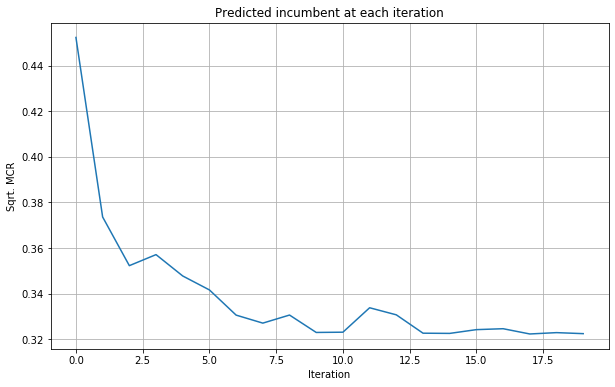

In [18]:
plt.figure(figsize=(10,6))
plt.plot(opt.y_inc) # plot predicted incumbent value at each iteration)
plt.xlabel('Iteration')
plt.ylabel('Sqrt. MCR')
plt.title('Predicted incumbent at each iteration')
plt.grid()
plt.show()

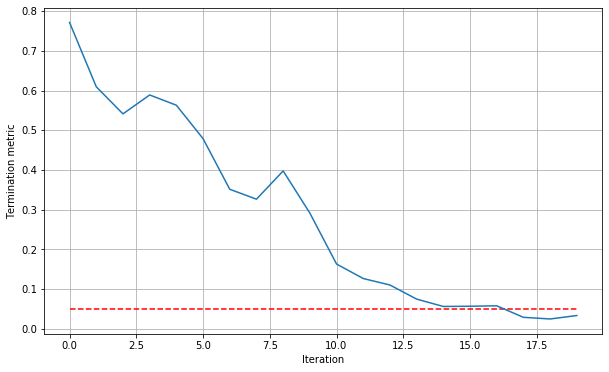

In [19]:
# plotting termination metric
plt.figure(figsize=(10,6))
plt.hlines(0.05,0,opt.max_iter-1,
           linestyles="dashed",colors="red")
plt.plot(opt.term_crit())
plt.xlabel('Iteration')
plt.ylabel('Termination metric')
plt.grid()
plt.show()

## Different initial configuration

In [20]:
# define optimizer object
opt_new = FCVOpt(clf,param_bounds,sqrt_mcr,kernel="matern",
                 logscale=np.array([0,1,2]),max_iter=20,
                 integer = [0],
                 seed=1234,verbose=2,
                 n_folds=5,n_init=4
            )

# tune hyperparameters
opt_new.fit(text,y)

  iter    f_best   acq_best    sigma_f
     0 5.640e-01 4.250e-01 1.068e-01
     1 4.875e-01 3.210e-01 1.365e-01
     2 4.808e-01 3.206e-01 1.368e-01
     3 4.756e-01 3.281e-01 1.490e-01
     4 4.457e-01 3.000e-01 1.446e-01
     5 4.363e-01 2.657e-01 1.523e-01
     6 4.101e-01 2.391e-01 1.600e-01
     7 3.887e-01 1.982e-01 1.744e-01
     8 3.922e-01 2.623e-01 1.997e-01
     9 3.717e-01 2.016e-01 1.934e-01
  iter    f_best   acq_best    sigma_f
    10 3.456e-01 1.981e-01 1.907e-01
    11 3.404e-01 2.053e-01 2.043e-01
    12 3.321e-01 2.400e-01 2.152e-01
    13 3.205e-01 2.533e-01 2.132e-01
    14 3.213e-01 2.760e-01 2.290e-01
    15 3.113e-01 2.827e-01 2.622e-01
    16 3.106e-01 2.920e-01 2.522e-01
    17 3.137e-01 2.866e-01 2.215e-01
    18 3.142e-01 2.946e-01 2.325e-01
    19 3.154e-01 2.973e-01 2.042e-01

Number of candidates evaluated.....: 20
Number of folds evaluated..........: 23
Estimated obj at incumbent.........: 0.315375
Estimated obj at candidate.........: 0.315497

Incumben

{'x_best': array([5.e+04, 1.e-06, 1.e+00]),
 'f_best': 0.3153754321036421,
 'acq_cand': 0.2973105153671892,
 'x_cand': array([5.00000000e+04, 2.38260521e-06, 1.00000000e+00])}

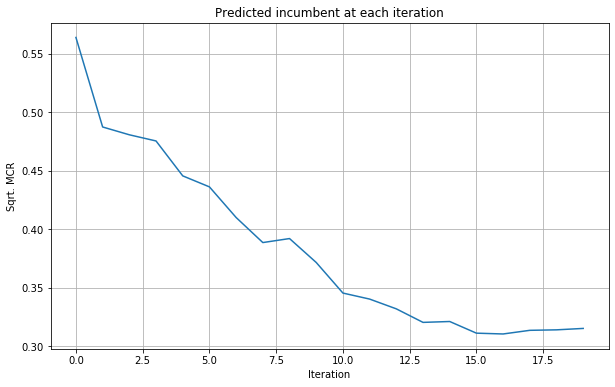

In [21]:
plt.figure(figsize=(10,6))
plt.plot(opt_new.y_inc) # plot predicted incumbent value at each iteration)
plt.xlabel('Iteration')
plt.ylabel('Sqrt. MCR')
plt.title('Predicted incumbent at each iteration')
plt.grid()
plt.show()

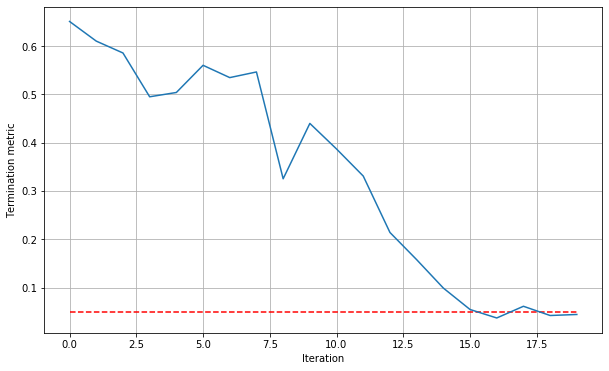

In [22]:
# plotting termination metric
plt.figure(figsize=(10,6))
plt.hlines(0.05,0,opt.max_iter-1,
           linestyles="dashed",colors="red")
plt.plot(opt_new.term_crit())
plt.xlabel('Iteration')
plt.ylabel('Termination metric')
plt.grid()
plt.show()